## Phase 4: Building and Training the AI Orchestrator

This notebook takes the dataset generated in Phase 3 and uses it to train a machine learning model. The goal is to create a classifier that can predict the best algorithm for a given problem instance based on its features.

Process:
1.  Load Data: Read the generated_dataset.csv file.
2.  Define "Best" Algorithm: For each problem instance, identify the winning algorithm based on its performance. This creates our target variable.
3.  Prepare for Training: Select features, encode categorical variables, and split the data into training and testing sets.
4.  Train the Model: Use a LightGBM classifier to learn the relationship between problem features and the best algorithm.
5.  Evaluate Performance: Assess the model's accuracy on the unseen test data.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the dataset
DATA_DIR = '../data'
DATA_FILE = os.path.join(DATA_DIR, 'generated_dataset.csv')

df = pd.read_csv(DATA_FILE)

print(f"Dataset loaded successfully with {len(df)} rows.")
df.head()

Dataset loaded successfully with 102 rows.


,instance_id,problem_type,algorithm,runtime_seconds,solution_quality,instance_size,data_mean,data_std_dev,data_skewness,data_kurtosis,data_min,data_max,data_q1,data_q3
0,tsp_instance_36.json,TSP,GA,2.481141,943,15,105.904762,40.505032,0.214874,-1.152037,33,183,75.00,142.0
1,tsp_instance_36.json,TSP,SA,6.684113,829,15,105.904762,40.505032,0.214874,-1.152037,33,183,75.00,142.0
2,tsp_instance_25.json,TSP,GA,2.368710,907,16,99.175000,40.778193,0.244822,-0.704596,19,196,66.75,127.5
3,tsp_instance_25.json,TSP,SA,6.464394,762,16,99.175000,40.778193,0.244822,-0.704596,19,196,66.75,127.5
4,tsp_instance_28.json,TSP,GA,2.507938,1643,24,102.898551,40.599991,0.068628,-0.742216,13,191,73.00,133.0


### Step 1: Define the "Best" Algorithm (Target Engineering)

This is the most critical preprocessing step. We need to create a is_best column to serve as our target variable for the model. For each unique instance_id, we identify the algorithm that performed best.

- For TSP, the best algorithm has the lowest solution_quality (shortest tour).
- For KP, the best algorithm has the highest solution_quality (most value).

In [2]:
# Use transform to find the index of the best run within each group
def find_best_idx(group):
    problem_type = group['problem_type'].iloc[0]
    if problem_type == 'TSP':
        # For TSP, lower is better
        return group['solution_quality'].idxmin()
    elif problem_type == 'KP':
        # For KP, higher is better
        return group['solution_quality'].idxmax()
    return None

# Get the index of the best row for each instance
best_indices = df.groupby('instance_id').apply(find_best_idx).tolist()

# Create the 'is_best' column
df['is_best'] = 0
df.loc[best_indices, 'is_best'] = 1

print("'is_best' column created.")
# Display a sample to verify the logic
df[df['instance_id'] == 'tsp_instance_01.json']

'is_best' column created.


/tmp/ipykernel_434894/2110840854.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_indices = df.groupby('instance_id').apply(find_best_idx).tolist()


,instance_id,problem_type,algorithm,runtime_seconds,solution_quality,instance_size,data_mean,data_std_dev,data_skewness,data_kurtosis,data_min,data_max,data_q1,data_q3,is_best
24,tsp_instance_01.json,TSP,GA,2.209496,254,11,33.618182,28.599104,1.364097,0.447518,3,101,15.0,36.5,0
25,tsp_instance_01.json,TSP,SA,8.372564,253,11,33.618182,28.599104,1.364097,0.447518,3,101,15.0,36.5,1


### Step 2: Prepare the Data for Training

Now we separate our data into features (X) and the target (y). We also convert categorical features like algorithm and problem_type into a numerical format using one-hot encoding.

In [3]:
# Define feature columns and categorical columns
feature_cols = [
    'instance_size', 'data_mean', 'data_std_dev', 'data_skewness', 
    'data_kurtosis', 'data_min', 'data_max', 'data_q1', 'data_q3'
]
categorical_cols = ['problem_type', 'algorithm']

# Create the feature matrix X
X = df[feature_cols].copy()

# Perform one-hot encoding for categorical variables
X_encoded = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)

# Combine numerical and encoded features
X = pd.concat([X, X_encoded], axis=1)

# Define the target vector y
y = df['is_best']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y # Stratify helps with imbalanced classes
)

print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")
X_train.head()

Data split into training (76 rows) and testing (26 rows) sets.


,instance_size,data_mean,data_std_dev,data_skewness,data_kurtosis,data_min,data_max,data_q1,data_q3,problem_type_TSP,algorithm_GA,algorithm_SA
23,14,105.857143,41.482572,-0.037046,-0.568956,16,189,77.0,130.5,True,False,True
59,26,106.470769,36.156794,-0.125272,-0.582764,16,187,82.0,135.0,True,False,True
30,23,102.873518,39.405561,0.080564,-0.530774,14,196,74.0,129.0,True,True,False
31,23,102.873518,39.405561,0.080564,-0.530774,14,196,74.0,129.0,True,False,True
101,25,102.846667,39.501179,0.021645,-0.595640,17,197,73.0,132.0,True,False,True


### Step 3: Train the LightGBM Model

With the data prepared, we can now train our classifier. LightGBM is a fast and efficient gradient boosting framework, perfect for this kind of tabular data problem.

In [4]:
print("Training the AI Orchestrator model...")

# Initialize and train the LightGBM classifier
model = lgb.LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train, y_train)

print("Model training complete!")

Training the AI Orchestrator model...
[LightGBM] [Info] Number of positive: 38, number of negative: 38
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

### Step 4: Evaluate Model Performance

Now we use the unseen test set to evaluate how well our model learned to predict the best algorithm. We'll look at overall accuracy and a more detailed classification report.

Model Accuracy on Test Set: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13

    accuracy                           1.00        26
   macro avg       1.00      1.00      1.00        26
weighted avg       1.00      1.00      1.00        26



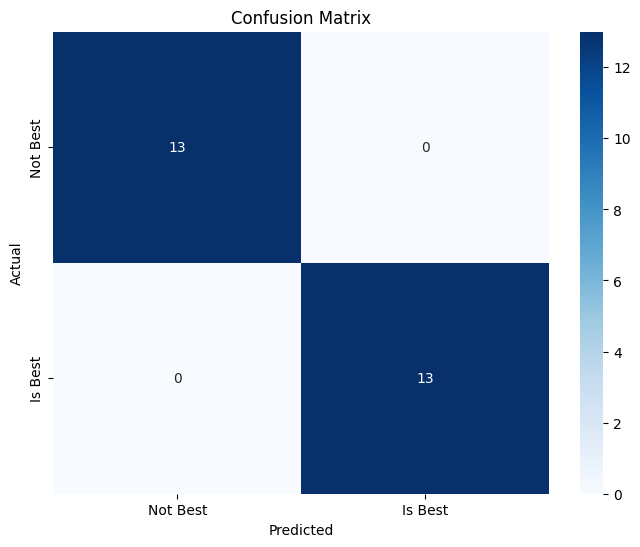

In [5]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.4f}\n")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Best', 'Is Best'], yticklabels=['Not Best', 'Is Best'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Feature Importance
Let's see which features the model found most important for making its decisions.

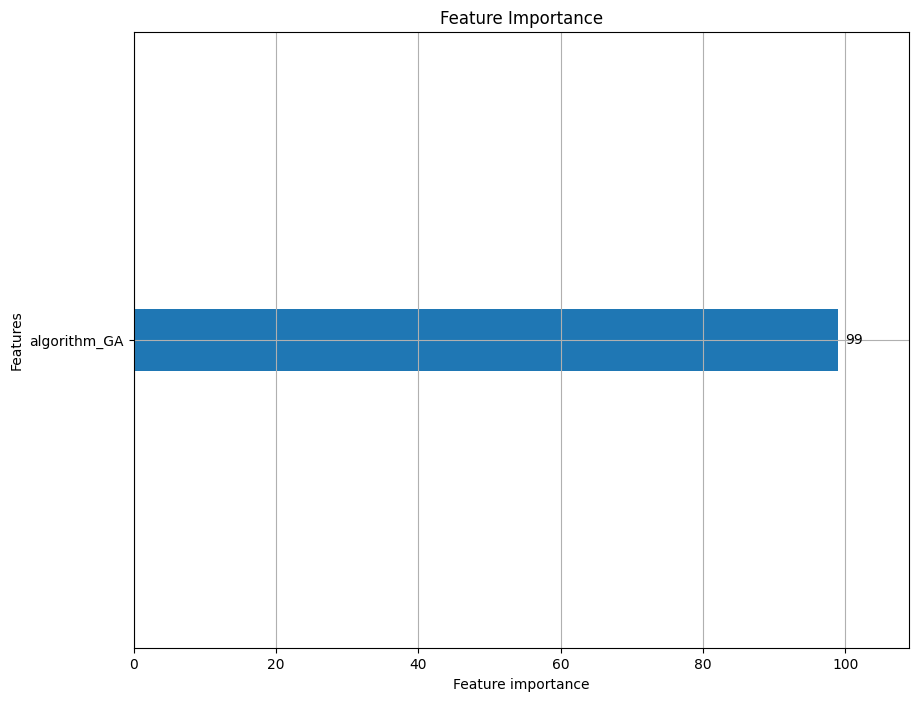

In [6]:
lgb.plot_importance(model, figsize=(10, 8), max_num_features=15)
plt.title('Feature Importance')
plt.show()